In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd

In [9]:
from datasets import load_dataset

In [10]:
dataset = load_dataset("aeslc")

Using custom data configuration default
Found cached dataset aeslc (C:/Users/mchou/.cache/huggingface/datasets/aeslc/default/1.0.0/eb8e30234cf984a58ebe9f205674597ac1db2ec91e7321cd7f36864f7e3671b8)


  0%|          | 0/3 [00:00<?, ?it/s]

# Import the dataset (Dataset is taken from kaggle)

In [17]:
source_train_df = pd.DataFrame(dataset["train"])
source_train_df.to_csv("train.csv",index=False)

In [18]:
validation_train_df = pd.DataFrame(dataset["validation"])

In [19]:
test_train_df = pd.DataFrame(dataset["test"])

In [20]:
data1_df = pd.read_csv("data\cnn\data1.csv")

In [21]:
data1_df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
0.0          393    389  You have received this message because someone...   
1.0         1509   1506  You have received this message because someone...   

               
         freq  
Category       
0.0         2  
1.0         4

In [22]:
data1_df['Category'].value_counts()

1.0    1509
0.0     393
Name: Category, dtype: int64

In [23]:
393/1509

0.26043737574552683

# 24% not pii, 76% pii: This indicates class imbalance

In [24]:

data1_df_pii = data1_df[data1_df['Category']==1]
data1_df_pii.shape

(1509, 2)

In [25]:
data1_df_no_pii = data1_df[data1_df['Category']==0]
data1_df_no_pii.shape

(393, 2)

In [26]:
data1_pii_downsampled = data1_df_pii.sample(data1_df_no_pii.shape[0])
data1_pii_downsampled.shape

(393, 2)

In [27]:
data1_balanced = pd.concat([data1_pii_downsampled, data1_df_no_pii])
data1_balanced.shape

(786, 2)

In [28]:
data1_balanced['Category'].value_counts()

0.0    393
1.0    393
Name: Category, dtype: int64

# Split it into training and test data set

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data1_balanced['Message'],data1_balanced['Category'], stratify=data1_balanced['Category'])

In [30]:
X_train.head(4)

1777    This is way over the top as far as what you an...
955                                       Topper, Stanton
31      John:  The Enron deal at Elba Island amounts t...
1761    Sally:  Thanks for the call today and I look f...
Name: Message, dtype: object

# Now lets import BERT model and get embeding vectors for few sample statements

In [31]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [32]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132727 , -0.8884572 , ..., -0.7474887 ,
        -0.75314736,  0.91964495],
       [-0.87208354, -0.50543964, -0.9444669 , ..., -0.8584749 ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

# Build Model


There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

In [33]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [35]:
len(X_train)

589

In [36]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train the model

In [37]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
19/19 [==============================] - 76s 4s/step - loss: 0.6155 - accuracy: 0.6621 - precision: 0.6589 - recall: 0.6746
Epoch 2/10
19/19 [==============================] - 73s 4s/step - loss: 0.4802 - accuracy: 0.8166 - precision: 0.8026 - recall: 0.8407
Epoch 3/10
19/19 [==============================] - 70s 4s/step - loss: 0.3926 - accuracy: 0.8676 - precision: 0.8581 - recall: 0.8814
Epoch 4/10
19/19 [==============================] - 65s 3s/step - loss: 0.3607 - accuracy: 0.8930 - precision: 0.8791 - recall: 0.9119
Epoch 5/10
19/19 [==============================] - 74s 4s/step - loss: 0.3269 - accuracy: 0.9066 - precision: 0.8922 - recall: 0.9254
Epoch 6/10
19/19 [==============================] - 73s 4s/step - loss: 0.2965 - accuracy: 0.9134 - precision: 0.9122 - recall: 0.9153
Epoch 7/10
19/19 [==============================] - 73s 4s/step - loss: 0.2770 - accuracy: 0.9202 - precision: 0.9133 - recall: 0.9288
Epoch 8/10
19/19 [==============================] - 71s

In [38]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 23s 3s/step - loss: 0.2612 - accuracy: 0.9492 - precision: 0.9783 - recall: 0.9184


[0.2611946761608124, 0.9492385983467102, 0.97826087474823, 0.918367326259613]

In [39]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

7/7 [==============================] - 23s 3s/step


In [40]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1])

In [41]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[97,  2],
       [ 8, 90]], dtype=int64)

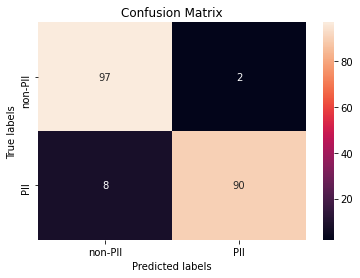

In [50]:
from matplotlib import pyplot as plt
import seaborn as sn
#sn.heatmap(cm, annot=True, fmt='d')
#plt.xlabel('Predicted')
#plt.ylabel('Truth')

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['non-PII', 'PII']); ax.yaxis.set_ticklabels(['non-PII', 'PII']);

In [51]:
print(classification_report(y_test, y_predicted, target_names=['non-PII','PII']))

              precision    recall  f1-score   support

     non-PII       0.92      0.98      0.95        99
         PII       0.98      0.92      0.95        98

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



In [36]:
import keras
from matplotlib import pyplot as plt
history = model.fit(X_train, y_train ,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Epoch 1/50
133/133 [==============================] - 81s 610ms/step - loss: 0.2406 - accuracy: 0.9415 - precision: 0.9470 - recall: 0.9363 - val_loss: 0.1905 - val_accuracy: 0.9492 - val_precision: 0.9630 - val_recall: 0.9286
Epoch 2/50
133/133 [==============================] - 83s 621ms/step - loss: 0.2211 - accuracy: 0.9509 - precision: 0.9617 - recall: 0.9401 - val_loss: 0.1493 - val_accuracy: 0.9661 - val_precision: 0.9643 - val_recall: 0.9643
Epoch 3/50
133/133 [==============================] - 79s 598ms/step - loss: 0.2023 - accuracy: 0.9434 - precision: 0.9506 - recall: 0.9363 - val_loss: 0.1366 - val_accuracy: 0.9661 - val_precision: 0.9643 - val_recall: 0.9643
Epoch 4/50
133/133 [==============================] - 79s 592ms/step - loss: 0.1979 - accuracy: 0.9472 - precision: 0.9614 - recall: 0.9326 - val_loss: 0.1228 - val_accuracy: 0.9661 - val_precision: 0.9643 - val_recall: 0.9643
Epoch 5/50
133/133 [==============================] - 82s 619ms/step - loss: 0.1839 - accura

Epoch 37/50
133/133 [==============================] - 83s 622ms/step - loss: 0.1327 - accuracy: 0.9717 - precision: 0.9884 - recall: 0.9551 - val_loss: 0.0486 - val_accuracy: 0.9831 - val_precision: 1.0000 - val_recall: 0.9643
Epoch 38/50
133/133 [==============================] - 86s 645ms/step - loss: 0.1438 - accuracy: 0.9566 - precision: 0.9766 - recall: 0.9363 - val_loss: 0.0545 - val_accuracy: 0.9661 - val_precision: 0.9643 - val_recall: 0.9643
Epoch 39/50
133/133 [==============================] - 85s 637ms/step - loss: 0.1356 - accuracy: 0.9698 - precision: 0.9922 - recall: 0.9476 - val_loss: 0.0666 - val_accuracy: 0.9831 - val_precision: 0.9655 - val_recall: 1.0000
Epoch 40/50
133/133 [==============================] - 83s 621ms/step - loss: 0.1370 - accuracy: 0.9604 - precision: 0.9767 - recall: 0.9438 - val_loss: 0.0463 - val_accuracy: 0.9831 - val_precision: 1.0000 - val_recall: 0.9643
Epoch 41/50
133/133 [==============================] - 81s 607ms/step - loss: 0.1412 - a

KeyError: 'acc'

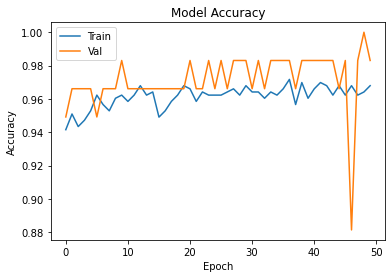

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [38]:
history

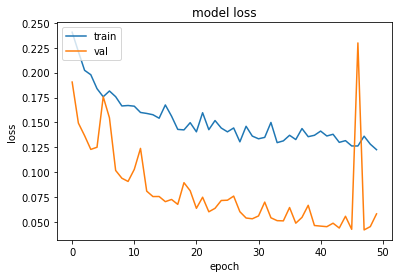

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()